# Python Analysis — CNC Tool Wear Data

This section presents the Python-based analysis for the CNC Milling Tool Wear dataset.  
The objective is to explore relationships among machine sensor variables and visualize correlation patterns that reveal subsystem dependencies and tool behavior.

In [23]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Found: ['experiment_01.csv', 'experiment_02.csv', 'experiment_03.csv', 'experiment_04.csv', 'experiment_05.csv', 'experiment_06.csv', 'experiment_07.csv', 'experiment_08.csv', 'experiment_09.csv', 'experiment_10.csv', 'experiment_11.csv', 'experiment_12.csv', 'experiment_13.csv', 'experiment_14.csv', 'experiment_15.csv', 'experiment_16.csv', 'experiment_17.csv', 'experiment_18.csv']


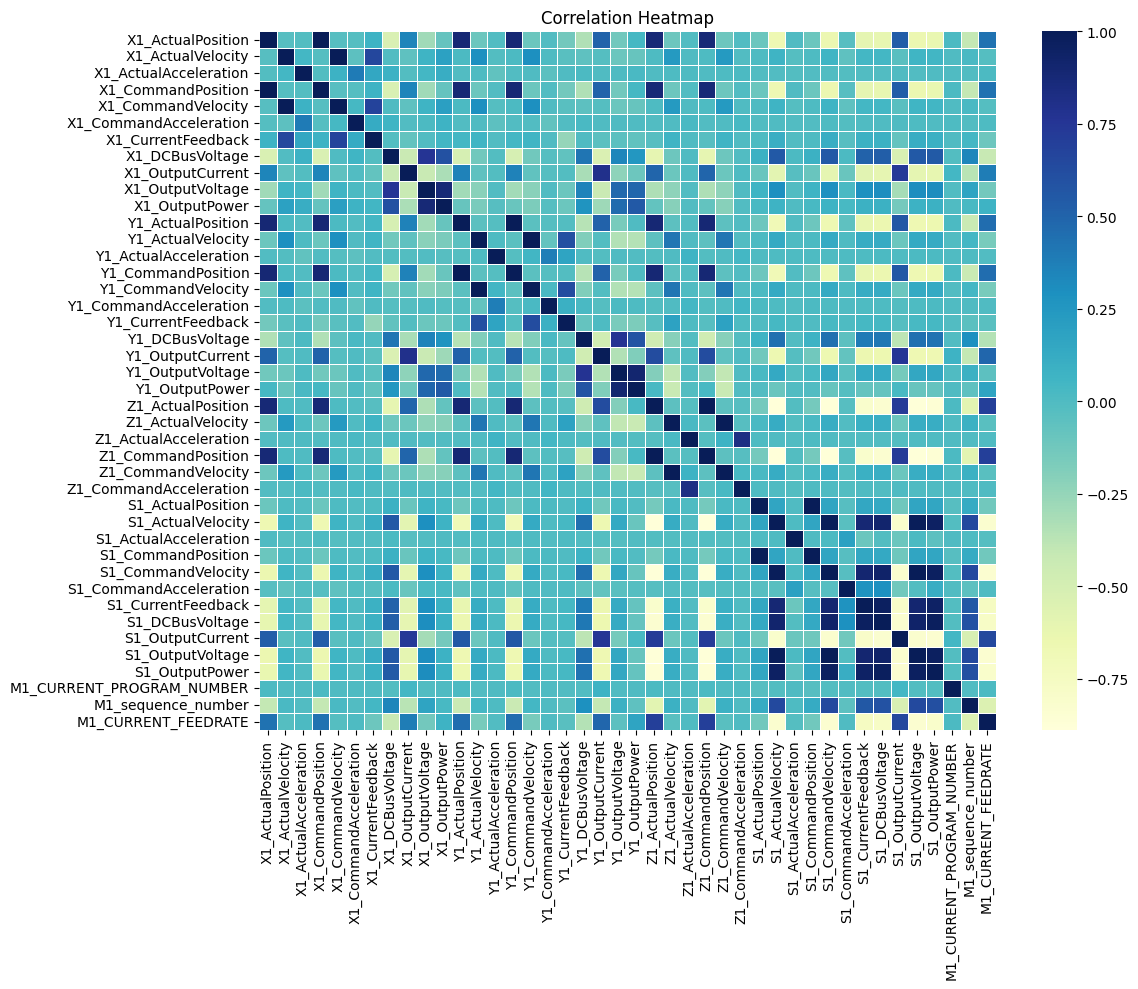

In [24]:
# 1) Find data files
root = Path(__file__).parent if "__file__" in globals() else Path().resolve()
data_dir = root.parent / "data" / "raw"

paths = sorted(data_dir.glob("experiment_*.csv"))
print("Found:", [p.name for p in paths])

if not paths:
    raise FileNotFoundError(f"No CSVs matched in {data_dir}")

# 2) Load and combine
df = pd.concat((pd.read_csv(p) for p in paths), ignore_index=True)

# 3) Numeric matrix + cleaning
X = df.select_dtypes("number").apply(pd.to_numeric, errors="coerce").fillna(0)
X = X.loc[:, X.nunique() > 1]

# 4) Correlation heatmap
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


### Why Cluster the Heatmap

Clustering the correlation matrix groups variables that behave similarly across experiments.  
In the CNC milling dataset, many sensor signals are correlated because they measure related machine behaviors (for example, spindle current, feed rate, and tool acceleration).

By applying hierarchical clustering:

- Variables with similar correlation patterns are positioned together, forming visible blocks on the heatmap.  
- It helps identify functional relationships between sensors (for example, current and velocity signals).  
- It reduces visual noise, making patterns and anomalies in tool behavior easier to interpret.  
- It supports feature selection by showing redundant or highly dependent variables that could be simplified in later modeling.

This step transforms a dense numeric correlation matrix into a structured visual summary of how the CNC machine’s operational parameters relate to


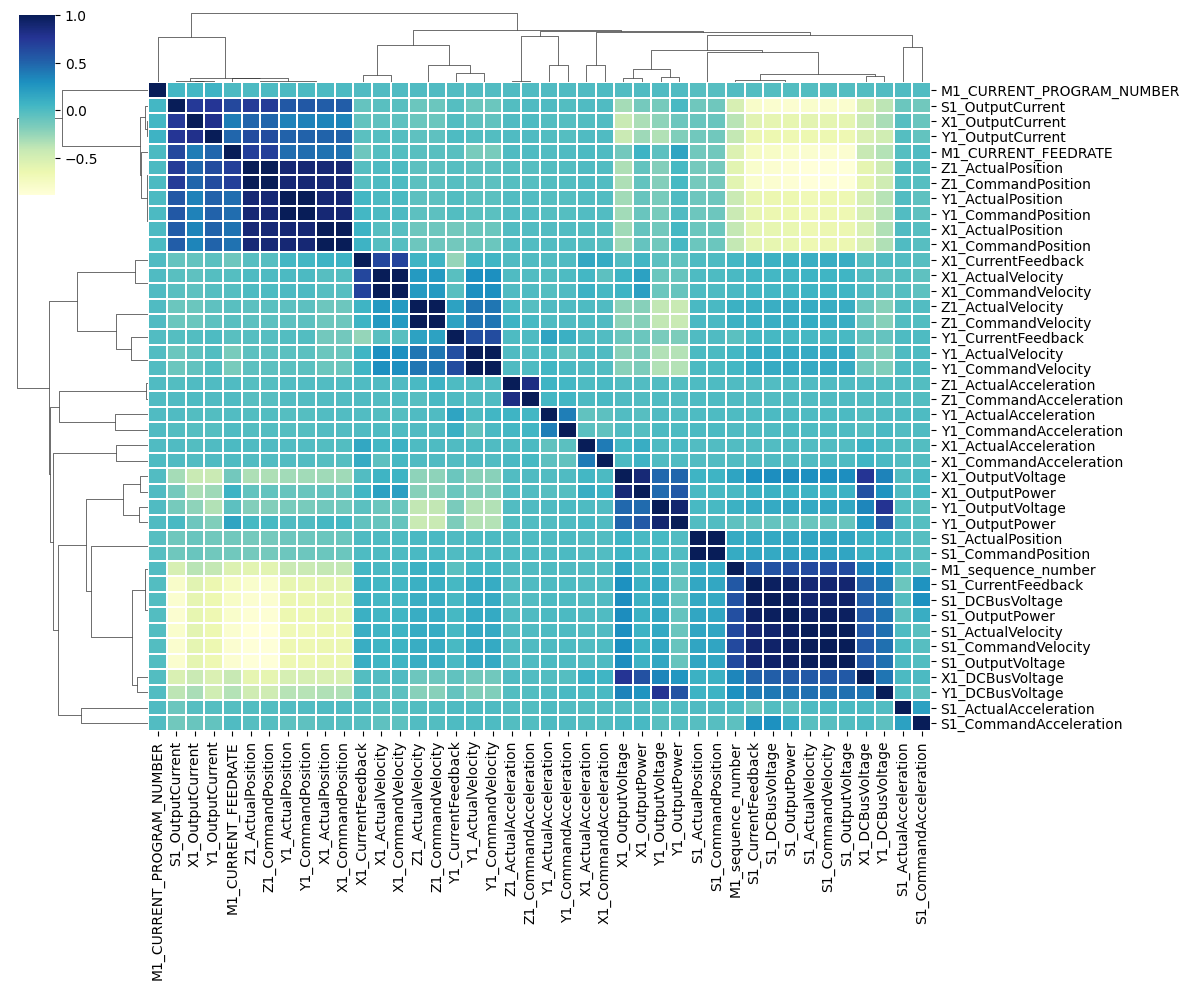

In [25]:
# clustered heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(
    corr,                   # from the previous cell
    metric="correlation",
    method="average",
    cmap="YlGnBu",
    linewidths=0.3,
    figsize=(12, 10),
    dendrogram_ratio=(0.15, 0.1),
    cbar_pos=(0.02, 0.8, 0.03, 0.18),
)
plt.show()


### PCA Projection of CNC Milling Data

Principal Component Analysis (PCA) reduces the many CNC sensor variables into a smaller number of dimensions while keeping most of the variance in the data.  
Each point in the PCA scatter plot represents one experiment or measurement condition, projected into the first two principal components (PC1 and PC2).

- The **explained variance ratio** shows how much of the total information these two components capture.  
- Points that appear close together share similar sensor behavior or operating states.  
- Points that are far apart indicate distinct machine conditions or possible tool wear differences.

This figure helps visualize the overall s


Explained variance ratio: [0.31865083 0.1144715 ]


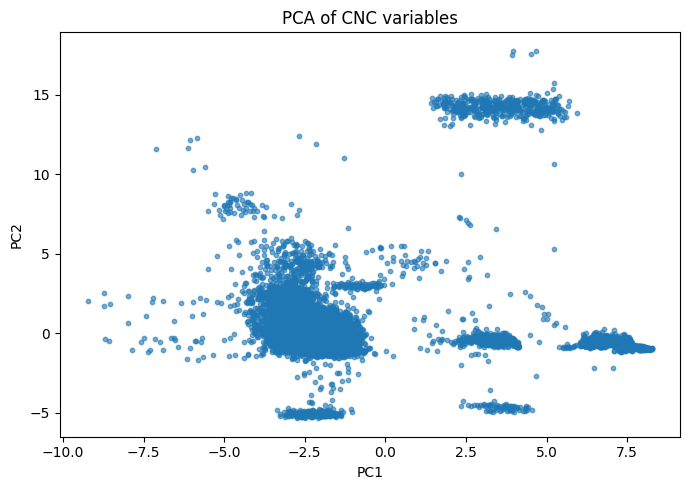

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
Xs = scaler.fit_transform(X)   # X from your data-cleaning cell

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xs)
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], s=10, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of CNC variables")
plt.tight_layout()
plt.show()


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init="auto", random_state=0)
    labels = km.fit_predict(Xs)
    scores[k] = silhouette_score(Xs, labels)

best_k = max(scores, key=scores.get)
best_k, scores


(3,
 {2: 0.40666362979634185,
  3: 0.41872035521317563,
  4: 0.36897471933824544,
  5: 0.22454114845154866,
  6: 0.23720244645620014,
  7: 0.23754436208475976,
  8: 0.22648540472607515})

### K-Means Clustering with Silhouette Evaluation

K-Means clustering groups CNC data points based on their similarity in sensor behavior.  
The algorithm assigns each observation to the nearest cluster center, aiming to minimize the variation within clusters and maximize separation between them.

To find a suitable number of clusters (**K**), the silhouette score was calculated for different K values.  
The silhouette score measures how well each point fits within its assigned cluster — values close to **1.0** indicate clear, well-separated groups.

- The best K corresponds to the **highest silhouette score**, showing the most distinct grouping of machine conditions.  
- In the PCA scatter plot, each color represents one cluster, summarizing similar operational patterns of the CNC machine.  
- Clusters often correspond to specific tool wear stages, load conditions, or axis behaviors.

This step complements the heatmap and PCA results by confirming that the CNC sensor data naturally divides into meaningful groups that can later support fault detection or predictive maintenance analysis.


In [28]:
df["Machining_Process"].unique()


array(['Starting', 'Prep', 'Layer 1 Up', 'Layer 1 Down', 'Repositioning',
       'Layer 2 Up', 'Layer 2 Down', 'Layer 3 Up', 'Layer 3 Down', 'end',
       'End'], dtype=object)

In [29]:
# group data by machining process and compute average load-related features
load_features = ['X1_OutputCurrent', 'Y1_OutputCurrent', 'Z1_OutputCurrent', 'S1_OutputCurrent']
df_grouped = df.groupby('Machining_Process')[load_features].mean().sort_values(by='S1_OutputCurrent', ascending=False)
df_grouped


,X1_OutputCurrent,Y1_OutputCurrent,Z1_OutputCurrent,S1_OutputCurrent
Machining_Process,,,,
Starting,329.000000,328.000000,0.0,329.000000
End,327.343133,326.099807,0.0,324.058027
Prep,327.331476,326.336490,0.0,323.840669
Repositioning,326.961800,326.064850,0.0,323.056263
Layer 3 Up,327.035433,325.884753,0.0,322.777380
Layer 1 Up,326.951775,325.815177,0.0,322.735618
Layer 2 Down,326.841377,325.814478,0.0,322.626187
Layer 1 Down,326.780038,325.803013,0.0,322.302072
Layer 3 Down,326.751062,325.621071,0.0,322.136364


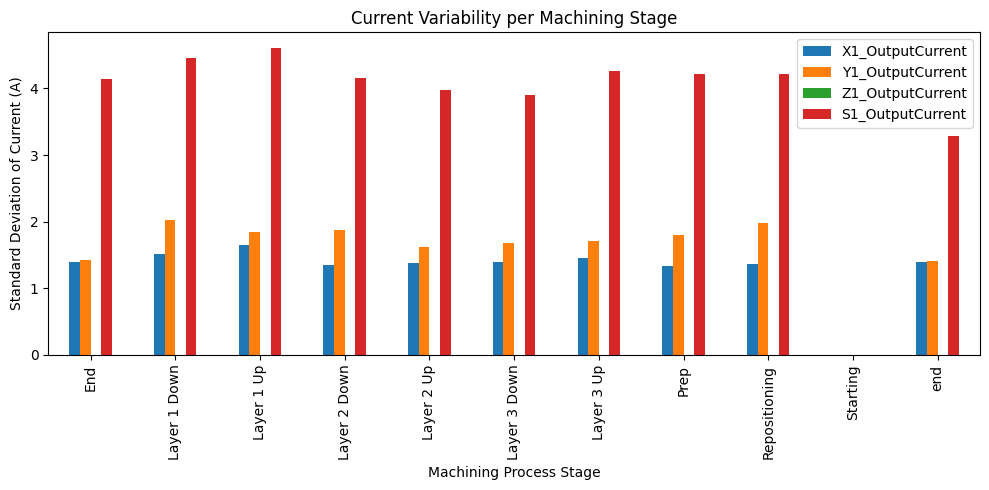

In [30]:
# Analyze variability in current by machining stage
load_features = ['X1_OutputCurrent', 'Y1_OutputCurrent', 'Z1_OutputCurrent', 'S1_OutputCurrent']
df_grouped_std = df.groupby('Machining_Process')[load_features].std()

df_grouped_std.plot(kind='bar', figsize=(10,5))
plt.title("Current Variability per Machining Stage")
plt.ylabel("Standard Deviation of Current (A)")
plt.xlabel("Machining Process Stage")
plt.tight_layout()
plt.show()

This figure shows current variability across machining stages. Higher variability may indicate increased tool stress or transient cutting forces, often associated with wear or unstable cutting conditions.